<a href="https://colab.research.google.com/github/e-margot/diploma/blob/main/Diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('cifar100-course-project')
jovian.set_colab_id('1UthhbwsF71kziQ8naC95rCbJfYuQfImO')

     |████████████████████████████████| 68 kB 5.2 MB/s 


# GETTING THE NECESSARY MODULES 

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

# SETTING THE PROJECT NAME

In [ ]:
project_name='cifar100-course-project'

# EXPLORING THE DATA

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

  0%|          | 0/169168619 [00:00<?, ?it/s]

In [ ]:
# Extract from archive
with tarfile.open('./cifar100.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

The dataset is extracted to the directory data/cifar100. 
It contains 2 folders train and test, containing the training set (50000 images) and test set (10000 images) respectively. 
Each of them contains 10 folders, one for each class of images. We can verify this using os.listdir.

In [ ]:
data_dir = './data/cifar100'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['household_furniture', 'large_man-made_outdoor_things', 'food_containers', 'fruit_and_vegetables', 'large_carnivores', 'vehicles_2', 'small_mammals', 'flowers', 'reptiles', 'medium_mammals', 'large_omnivores_and_herbivores', 'non-insect_invertebrates', 'people', 'fish', 'trees', 'insects', 'household_electrical_devices', 'large_natural_outdoor_scenes', 'aquatic_mammals', 'vehicles_1']


In [ ]:
x=len(os.listdir('./data/cifar100/train'))
print(f"No. of classes: {x}")
y=len(os.listdir('./data/cifar100/train/aquatic_mammals'))
print(f"No. of sub classes in each class: {y}")
z=len(os.listdir('./data/cifar100/train/aquatic_mammals/beaver'))
print(f"Total objects inside a subclass: {z}")

print(f"TRAINING SET CONTAINS {x*y*z} IMAGES")

No. of classes: 20
No. of sub classes in each class: 5
Total objects inside a subclass: 500
TRAINING SET CONTAINS 50000 IMAGES


In [ ]:
x=len(os.listdir('./data/cifar100/test'))
print(f"No. of classes: {x}")
y=len(os.listdir('./data/cifar100/test/aquatic_mammals'))
print(f"No. of sub classes in each class: {y}")
z=len(os.listdir('./data/cifar100/test/aquatic_mammals/beaver'))
print(f"Total objects inside a subclass: {z}")

print(f"TESTING SET CONTAINS {x*y*z} IMAGES")

No. of classes: 20
No. of sub classes in each class: 5
Total objects inside a subclass: 100
TESTING SET CONTAINS 10000 IMAGES


In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

# CHECKING AN IMAGE OF THE DATASET

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0)) #channel are at the last in matplotlib where it was at front in tensors

Label:  aquatic_mammals (0)


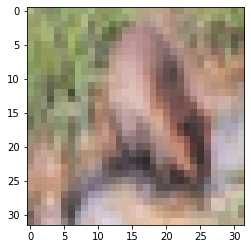

In [ ]:
show_example(*dataset[6]) #args use 

# Training and Validation Datasets

1)Let's normalize our data for uniformity(Standard Normal Deviation).

2)Let's apply randomly chosen transformations while loading images from the training dataset.

3)Let's take the validation set from the test dataset instead of allocating certain portion of training dataset.


In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)
test_ds = ImageFolder(data_dir+'/test', valid_tfms)

Let's create data loaders for retrieving images in batches as using the whole dataset isnot that effective in terms of memory and time so we shall create batches of data from the exisitng dataset and work on them

In [ ]:
batch_size = 250

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's take a look at some sample images from the training dataloader.

Each elemet of the dataloader is a tuple containing a image tensor and a label .
Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape (3, 32, 32).

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([250, 3, 32, 32])


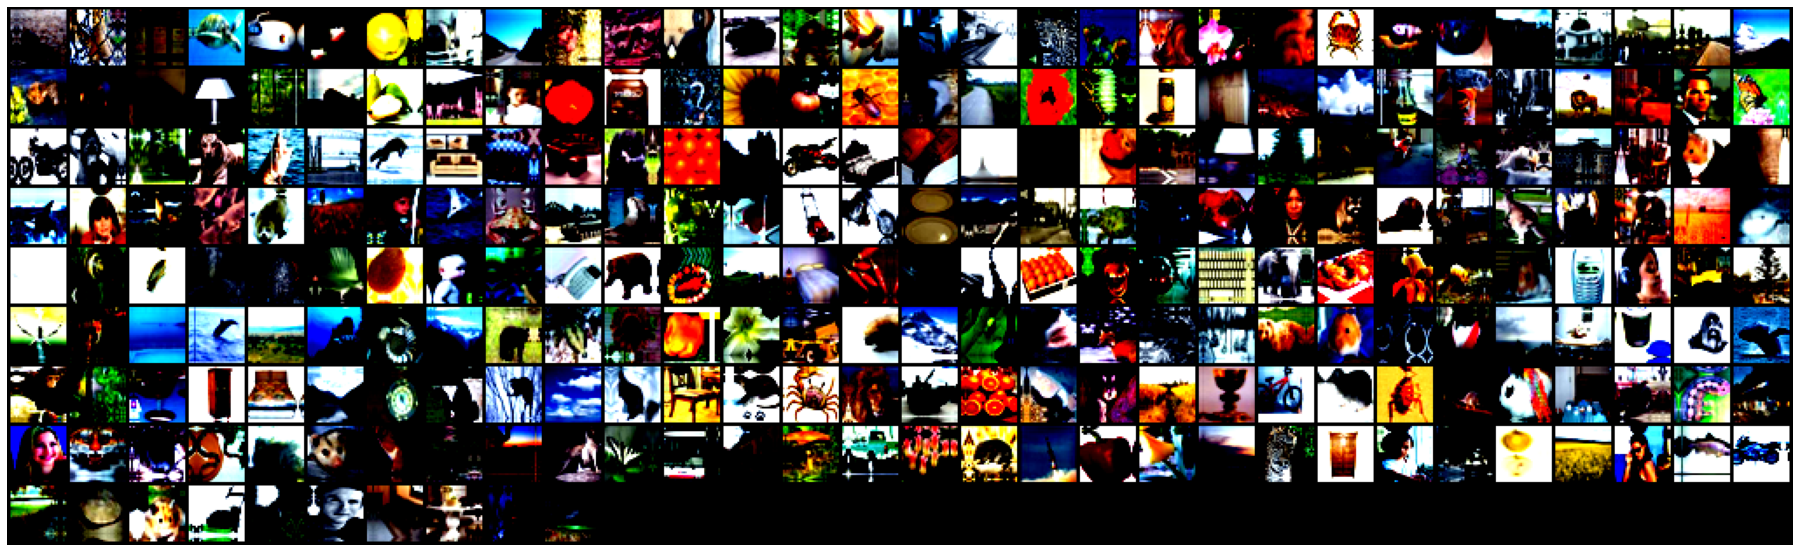

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(32,32))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=30).permute((1, 2, 0)))
    break

## lets view our batch of images

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


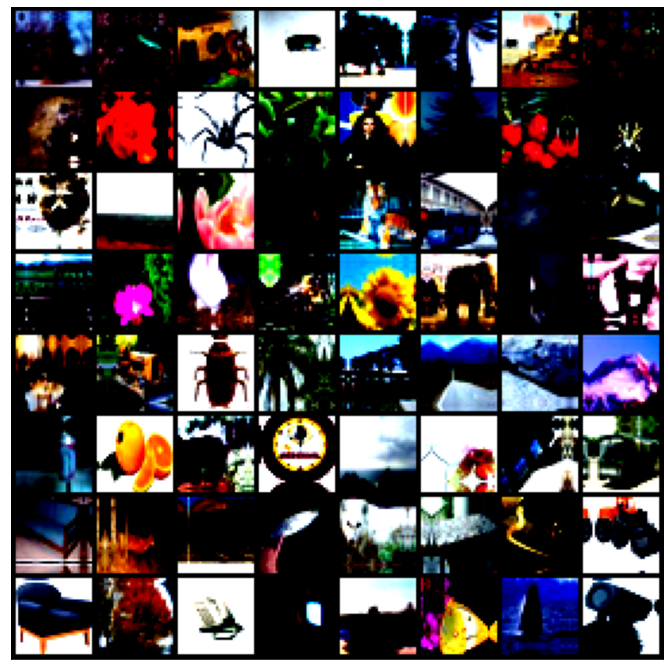

In [ ]:
show_batch(train_dl)

# MAKING USE OF GPU (IF PRESENT)

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available), and use to_device to move our model to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# LET'S WORK TOWARDS OUR MODEL  

## EXTENDING THE MODEL

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
resnet34 = models.resnet34()
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class CIFAR100Resnet(ImageClassificationBase):
        def __init__(self):
                super().__init__()
                self.network = torchvision.models.resnet34()
                num_ftrs = self.network.fc.in_features
                self.network.fc = nn.Linear(num_ftrs, 100)
        
        def forward(self, xb):
                return self.network(xb)
            
model = CIFAR100Resnet()
model

CIFAR100Resnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

# TRAINING THE MODEL

In [ ]:
model = to_device(CIFAR100Resnet(), device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, 
        weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.01599999889731407, 'val_loss': 5.982295513153076}]

In [ ]:
# For this model we gonna use Adam Optimization
opt_func = torch.optim.Adam

In [ ]:
history = fit(8, 1e-3, model, train_dl, valid_dl, 5e-4, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.4344, val_loss: 2.2057, val_acc: 0.3030
Epoch [1], train_loss: 2.0488, val_loss: 1.9866, val_acc: 0.3829
Epoch [2], train_loss: 1.8656, val_loss: 1.8568, val_acc: 0.4162
Epoch [3], train_loss: 1.7555, val_loss: 1.8081, val_acc: 0.4333
Epoch [4], train_loss: 1.6649, val_loss: 1.7912, val_acc: 0.4548
Epoch [5], train_loss: 1.5900, val_loss: 1.7890, val_acc: 0.4439
Epoch [6], train_loss: 1.5209, val_loss: 1.5935, val_acc: 0.5008
Epoch [7], train_loss: 1.4650, val_loss: 1.6125, val_acc: 0.4989


In [ ]:
history = fit(10, 1e-5, model, train_dl, valid_dl, 5e-4, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.3133, val_loss: 1.2837, val_acc: 0.5942
Epoch [1], train_loss: 1.2556, val_loss: 1.2587, val_acc: 0.5994
Epoch [2], train_loss: 1.2237, val_loss: 1.2412, val_acc: 0.6060
Epoch [3], train_loss: 1.1996, val_loss: 1.2319, val_acc: 0.6115
Epoch [4], train_loss: 1.1876, val_loss: 1.2269, val_acc: 0.6112
Epoch [5], train_loss: 1.1738, val_loss: 1.2192, val_acc: 0.6144
Epoch [6], train_loss: 1.1634, val_loss: 1.2183, val_acc: 0.6126
Epoch [7], train_loss: 1.1577, val_loss: 1.2150, val_acc: 0.6143
Epoch [8], train_loss: 1.1411, val_loss: 1.2061, val_acc: 0.6161
Epoch [9], train_loss: 1.1371, val_loss: 1.2088, val_acc: 0.6175


In [ ]:
history = fit(5, 1e-4, model, train_dl, valid_dl, 5e-4, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.7844, val_loss: 2.3877, val_acc: 0.2701
Epoch [1], train_loss: 2.3322, val_loss: 2.2044, val_acc: 0.3203
Epoch [2], train_loss: 2.1902, val_loss: 2.0924, val_acc: 0.3511
Epoch [3], train_loss: 2.0891, val_loss: 2.0127, val_acc: 0.3744
Epoch [4], train_loss: 1.9972, val_loss: 1.9451, val_acc: 0.3940


In [ ]:
history = fit(15, 1e-4, model, train_dl, valid_dl, 5e-4, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.7947, val_loss: 2.3978, val_acc: 0.2608
Epoch [1], train_loss: 2.3422, val_loss: 2.2250, val_acc: 0.3115
Epoch [2], train_loss: 2.2172, val_loss: 2.1288, val_acc: 0.3430
Epoch [3], train_loss: 2.1089, val_loss: 2.0419, val_acc: 0.3668
Epoch [4], train_loss: 2.0260, val_loss: 1.9838, val_acc: 0.3770
Epoch [5], train_loss: 1.9521, val_loss: 1.9258, val_acc: 0.4015


In [ ]:
history = fit(25, 1e-5, model, train_dl, valid_dl, 5e-4, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 4.0129, val_loss: 3.3817, val_acc: 0.1418
Epoch [1], train_loss: 3.0971, val_loss: 2.8845, val_acc: 0.1847
Epoch [2], train_loss: 2.7984, val_loss: 2.6913, val_acc: 0.2030
Epoch [3], train_loss: 2.6630, val_loss: 2.5850, val_acc: 0.2217
Epoch [4], train_loss: 2.5751, val_loss: 2.5129, val_acc: 0.2376
Epoch [5], train_loss: 2.5168, val_loss: 2.4547, val_acc: 0.2473
Epoch [6], train_loss: 2.4675, val_loss: 2.4065, val_acc: 0.2656
Epoch [7], train_loss: 2.4280, val_loss: 2.3652, val_acc: 0.2761
Epoch [8], train_loss: 2.3846, val_loss: 2.3274, val_acc: 0.2834
Epoch [9], train_loss: 2.3557, val_loss: 2.2980, val_acc: 0.2904
Epoch [10], train_loss: 2.3262, val_loss: 2.2727, val_acc: 0.2990


# MAKING PREDICTIONS 

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: aquatic_mammals , Predicted: medium_mammals


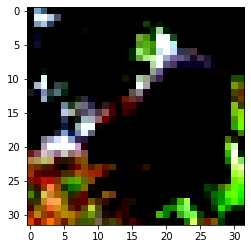

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: flowers , Predicted: flowers


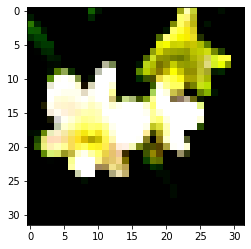

In [ ]:
img, label = test_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: household_furniture , Predicted: household_furniture


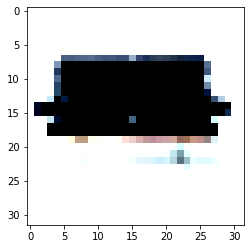

In [ ]:
img, label = test_ds[3252]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.49889999628067017, 'val_loss': 1.6125202178955078}

# GRAPHICAL REPRESENTATION OF SOME TERMS 

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

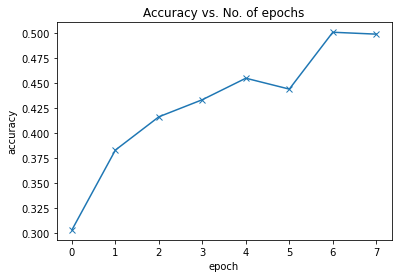

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

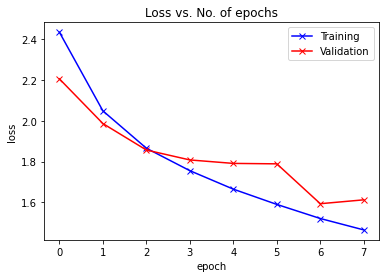

In [ ]:
plot_losses(history)

# USING JOVIAN TO RECORD NECESSARY INFORMATION

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
# Here we save the used parameters.
import jovian

jovian.reset()
jovian.log_hyperparams({
    'num_epochs': [8, 10, 5, 15,25],
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': [1e-3, 1e-5, 1e-4, 1e-4, 1e-5],
    'weight_decay': 5e-4
})

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [ ]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


In [ ]:
torch.save(model.state_dict(), 'cifar100-resnet-course-project.pth')

In [ ]:
jovian.commit(project=project_name, environment=None)


[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/e-margot/cifar100-course-project


'https://jovian.ai/e-margot/cifar100-course-project'